[View in Colaboratory](https://colab.research.google.com/github/yylonly/GoogleCoLab/blob/master/4_ServeNet_LTSM_(Glove100b_trainedEmbeddingLayer).ipynb)

## ServeNet-LTSM (Glove100b-trainedEmbeddingLayer)

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("/content/drive/Colab Notebooks/")

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import os
os.chdir("/content/drive/Colab Notebooks/")

In [0]:
!ls a

10.TensorFlow
14.Residual Networks
15.CarDetectionwithYOLOv2
16.Neural Style Transfer
17.Face Recognition
1.Python Basics with Numpy
2.Logistic Regression as a Neural Network
4.ServeNet-LTSM (Glove100b-trainedEmbeddingLayer).ipynb
CalligraphyColorNet.ipynb
CalligraphyNet.ipynb
Copy of CalligraphyColorNet (019b6ded).ipynb
Copy of CalligraphyColorNet.ipynb
Copy of Hello, Colaboratory
data
datasets
env.ipynb
glove50-checkpoints.hdf5
glove50-loss.pdf
glove50-top5.pdf
images
ORGANIC.ipynb
pix2pix.ipynb
ServeNet
Serve_Net_Glove50.h5
SQCalligraphyNet.ipynb
tensorflowtest.ipynb
top5.pdf


In [0]:
!pip install keras==2.0.8

    100% |████████████████████████████████| 276kB 4.6MB/s 
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6


In [0]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import csv
import h5py

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint

np.random.seed(0)
%matplotlib inline

Using TensorFlow backend.


In [0]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [0]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [0]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.100d.txt')
word_to_vec_map["cucumber"].shape[0]

100

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
# GRADED FUNCTION: Emojify_V2

def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(256, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(256, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(50)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your model and check its summary. Because all sentences in the dataset are less than 10 words, we chose `max_len = 10`.  You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [0]:
maxLen = 110

In [0]:
model = ServeNet((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 110, 100)          40000100  
_________________________________________________________________
lstm_3 (LSTM)                (None, 110, 256)          365568    
_________________________________________________________________
dropout_3 (Dropout)          (None, 110, 256)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                12850     
__________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
filepath = "glove50-checkpoints.hdf5"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='acc')

In [0]:
from keras.callbacks import Callback

class WeightsSaver(Callback):
    def __init__(self, model, N):
        self.model = model
        self.N = N
        self.batch = 0

    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            name = 'weights%08d.h5' % self.batch
            self.model.save_weights(name)
        self.batch += 1

In [0]:
#history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100, batch_size = 128, callbacks=[WeightsSaver(model, 5)])
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100, batch_size = 128)

Train on 8123 samples, validate on 2061 samples
Epoch 1/100
8123/8123 [==============================] - 33s - loss: 3.7479 - categorical_accuracy: 0.0661 - top_k_categorical_accuracy: 0.2543 - val_loss: 3.7233 - val_categorical_accuracy: 0.0728 - val_top_k_categorical_accuracy: 0.2606
Epoch 2/100
8123/8123 [==============================] - 33s - loss: 3.7276 - categorical_accuracy: 0.0675 - top_k_categorical_accuracy: 0.2630 - val_loss: 3.7170 - val_categorical_accuracy: 0.0728 - val_top_k_categorical_accuracy: 0.2625
Epoch 3/100
8123/8123 [==============================] - 34s - loss: 3.7563 - categorical_accuracy: 0.0696 - top_k_categorical_accuracy: 0.2538 - val_loss: 3.7488 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2610
Epoch 4/100
1920/8123 [======>.......................] - ETA: 24s - loss: 3.7497 - categorical_accuracy: 0.0615 - top_k_categorical_accuracy: 0.2516

8123/8123 [==============================] - 33s - loss: 3.7412 - categorical_accuracy: 0.0678 - top_k_categorical_accuracy: 0.2562 - val_loss: 3.7190 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2606
Epoch 5/100
8123/8123 [==============================] - 33s - loss: 3.7322 - categorical_accuracy: 0.0689 - top_k_categorical_accuracy: 0.2609 - val_loss: 3.7182 - val_categorical_accuracy: 0.0713 - val_top_k_categorical_accuracy: 0.2606
Epoch 6/100
8123/8123 [==============================] - 33s - loss: 3.7311 - categorical_accuracy: 0.0673 - top_k_categorical_accuracy: 0.2570 - val_loss: 3.7167 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2639
Epoch 7/100
4224/8123 [==============>...............] - ETA: 15s - loss: 3.7283 - categorical_accuracy: 0.0658 - top_k_categorical_accuracy: 0.2628

8123/8123 [==============================] - 34s - loss: 3.7282 - categorical_accuracy: 0.0707 - top_k_categorical_accuracy: 0.2582 - val_loss: 3.7180 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2639
Epoch 8/100
8123/8123 [==============================] - 34s - loss: 3.7270 - categorical_accuracy: 0.0712 - top_k_categorical_accuracy: 0.2575 - val_loss: 3.7174 - val_categorical_accuracy: 0.0631 - val_top_k_categorical_accuracy: 0.2610
Epoch 9/100
8123/8123 [==============================] - 34s - loss: 3.7242 - categorical_accuracy: 0.0699 - top_k_categorical_accuracy: 0.2607 - val_loss: 3.7159 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2639
Epoch 10/100
4480/8123 [===============>..............] - ETA: 14s - loss: 3.7243 - categorical_accuracy: 0.0705 - top_k_categorical_accuracy: 0.2580

8123/8123 [==============================] - 34s - loss: 3.7214 - categorical_accuracy: 0.0699 - top_k_categorical_accuracy: 0.2623 - val_loss: 3.7162 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2639
Epoch 11/100
8123/8123 [==============================] - 34s - loss: 3.7204 - categorical_accuracy: 0.0681 - top_k_categorical_accuracy: 0.2626 - val_loss: 3.7170 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2639
Epoch 12/100
8123/8123 [==============================] - 34s - loss: 3.7212 - categorical_accuracy: 0.0704 - top_k_categorical_accuracy: 0.2658 - val_loss: 3.7173 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2639
Epoch 13/100
4480/8123 [===============>..............] - ETA: 14s - loss: 3.6994 - categorical_accuracy: 0.0779 - top_k_categorical_accuracy: 0.2759

8123/8123 [==============================] - 34s - loss: 3.7206 - categorical_accuracy: 0.0683 - top_k_categorical_accuracy: 0.2618 - val_loss: 3.7203 - val_categorical_accuracy: 0.0631 - val_top_k_categorical_accuracy: 0.2639
Epoch 14/100
8123/8123 [==============================] - 34s - loss: 3.7226 - categorical_accuracy: 0.0696 - top_k_categorical_accuracy: 0.2584 - val_loss: 3.7156 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2639
Epoch 15/100
8123/8123 [==============================] - 34s - loss: 3.7205 - categorical_accuracy: 0.0677 - top_k_categorical_accuracy: 0.2595 - val_loss: 3.7159 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2639
Epoch 16/100
4480/8123 [===============>..............] - ETA: 14s - loss: 3.7277 - categorical_accuracy: 0.0676 - top_k_categorical_accuracy: 0.2547

8123/8123 [==============================] - 34s - loss: 3.7182 - categorical_accuracy: 0.0714 - top_k_categorical_accuracy: 0.2630 - val_loss: 3.7157 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2610
Epoch 17/100
8123/8123 [==============================] - 34s - loss: 3.7199 - categorical_accuracy: 0.0703 - top_k_categorical_accuracy: 0.2644 - val_loss: 3.7156 - val_categorical_accuracy: 0.0718 - val_top_k_categorical_accuracy: 0.2625
Epoch 18/100
8123/8123 [==============================] - 34s - loss: 3.7148 - categorical_accuracy: 0.0741 - top_k_categorical_accuracy: 0.2643 - val_loss: 3.7104 - val_categorical_accuracy: 0.0810 - val_top_k_categorical_accuracy: 0.2693
Epoch 19/100
4480/8123 [===============>..............] - ETA: 14s - loss: 3.7123 - categorical_accuracy: 0.0797 - top_k_categorical_accuracy: 0.2636

8123/8123 [==============================] - 34s - loss: 3.7181 - categorical_accuracy: 0.0735 - top_k_categorical_accuracy: 0.2622 - val_loss: 3.7140 - val_categorical_accuracy: 0.0781 - val_top_k_categorical_accuracy: 0.2635
Epoch 20/100
8123/8123 [==============================] - 34s - loss: 3.7146 - categorical_accuracy: 0.0774 - top_k_categorical_accuracy: 0.2611 - val_loss: 3.6790 - val_categorical_accuracy: 0.0946 - val_top_k_categorical_accuracy: 0.2732
Epoch 21/100
8123/8123 [==============================] - 34s - loss: 3.6367 - categorical_accuracy: 0.1027 - top_k_categorical_accuracy: 0.2924 - val_loss: 3.5984 - val_categorical_accuracy: 0.0932 - val_top_k_categorical_accuracy: 0.3100
Epoch 22/100
4480/8123 [===============>..............] - ETA: 14s - loss: 3.5427 - categorical_accuracy: 0.1156 - top_k_categorical_accuracy: 0.3375

8123/8123 [==============================] - 34s - loss: 3.4873 - categorical_accuracy: 0.1250 - top_k_categorical_accuracy: 0.3496 - val_loss: 3.3897 - val_categorical_accuracy: 0.1203 - val_top_k_categorical_accuracy: 0.3833
Epoch 23/100
8123/8123 [==============================] - 33s - loss: 3.3295 - categorical_accuracy: 0.1555 - top_k_categorical_accuracy: 0.3997 - val_loss: 3.2703 - val_categorical_accuracy: 0.1562 - val_top_k_categorical_accuracy: 0.4124
Epoch 24/100
8123/8123 [==============================] - 34s - loss: 3.1920 - categorical_accuracy: 0.1685 - top_k_categorical_accuracy: 0.4391 - val_loss: 3.1250 - val_categorical_accuracy: 0.1718 - val_top_k_categorical_accuracy: 0.4580
Epoch 25/100
4480/8123 [===============>..............] - ETA: 14s - loss: 3.1000 - categorical_accuracy: 0.1804 - top_k_categorical_accuracy: 0.4634

8123/8123 [==============================] - 34s - loss: 3.0828 - categorical_accuracy: 0.1823 - top_k_categorical_accuracy: 0.4698 - val_loss: 3.0466 - val_categorical_accuracy: 0.1727 - val_top_k_categorical_accuracy: 0.4837
Epoch 26/100
8123/8123 [==============================] - 34s - loss: 3.0170 - categorical_accuracy: 0.1922 - top_k_categorical_accuracy: 0.4903 - val_loss: 2.9889 - val_categorical_accuracy: 0.1955 - val_top_k_categorical_accuracy: 0.5197
Epoch 27/100
8123/8123 [==============================] - 34s - loss: 2.9249 - categorical_accuracy: 0.1998 - top_k_categorical_accuracy: 0.5273 - val_loss: 2.9763 - val_categorical_accuracy: 0.1975 - val_top_k_categorical_accuracy: 0.5027
Epoch 28/100
4480/8123 [===============>..............] - ETA: 14s - loss: 2.8838 - categorical_accuracy: 0.2029 - top_k_categorical_accuracy: 0.5522

8123/8123 [==============================] - 34s - loss: 2.8533 - categorical_accuracy: 0.2137 - top_k_categorical_accuracy: 0.5609 - val_loss: 2.8366 - val_categorical_accuracy: 0.2179 - val_top_k_categorical_accuracy: 0.5594
Epoch 29/100
8123/8123 [==============================] - 34s - loss: 2.7312 - categorical_accuracy: 0.2476 - top_k_categorical_accuracy: 0.5977 - val_loss: 2.7455 - val_categorical_accuracy: 0.2329 - val_top_k_categorical_accuracy: 0.5847
Epoch 30/100
8123/8123 [==============================] - 33s - loss: 2.6512 - categorical_accuracy: 0.2596 - top_k_categorical_accuracy: 0.6228 - val_loss: 2.7361 - val_categorical_accuracy: 0.2465 - val_top_k_categorical_accuracy: 0.6007
Epoch 31/100
4480/8123 [===============>..............] - ETA: 14s - loss: 2.5989 - categorical_accuracy: 0.2761 - top_k_categorical_accuracy: 0.6440

8123/8123 [==============================] - 34s - loss: 2.5675 - categorical_accuracy: 0.2834 - top_k_categorical_accuracy: 0.6493 - val_loss: 2.6514 - val_categorical_accuracy: 0.2838 - val_top_k_categorical_accuracy: 0.6269
Epoch 32/100
8123/8123 [==============================] - 34s - loss: 2.4983 - categorical_accuracy: 0.3052 - top_k_categorical_accuracy: 0.6578 - val_loss: 2.5023 - val_categorical_accuracy: 0.3241 - val_top_k_categorical_accuracy: 0.6511
Epoch 33/100
8123/8123 [==============================] - 34s - loss: 2.3576 - categorical_accuracy: 0.3592 - top_k_categorical_accuracy: 0.6837 - val_loss: 2.4579 - val_categorical_accuracy: 0.3338 - val_top_k_categorical_accuracy: 0.6642
Epoch 34/100
4480/8123 [===============>..............] - ETA: 14s - loss: 2.2944 - categorical_accuracy: 0.3672 - top_k_categorical_accuracy: 0.7040

8123/8123 [==============================] - 33s - loss: 2.2559 - categorical_accuracy: 0.3842 - top_k_categorical_accuracy: 0.7125 - val_loss: 2.3791 - val_categorical_accuracy: 0.3688 - val_top_k_categorical_accuracy: 0.6851
Epoch 35/100
8123/8123 [==============================] - 34s - loss: 2.1753 - categorical_accuracy: 0.4045 - top_k_categorical_accuracy: 0.7321 - val_loss: 2.2954 - val_categorical_accuracy: 0.3852 - val_top_k_categorical_accuracy: 0.7026
Epoch 36/100
8123/8123 [==============================] - 34s - loss: 2.0684 - categorical_accuracy: 0.4347 - top_k_categorical_accuracy: 0.7506 - val_loss: 2.2427 - val_categorical_accuracy: 0.4056 - val_top_k_categorical_accuracy: 0.7166
Epoch 37/100
4480/8123 [===============>..............] - ETA: 14s - loss: 1.9203 - categorical_accuracy: 0.4757 - top_k_categorical_accuracy: 0.7842

8123/8123 [==============================] - 34s - loss: 1.9362 - categorical_accuracy: 0.4719 - top_k_categorical_accuracy: 0.7777 - val_loss: 2.1716 - val_categorical_accuracy: 0.4328 - val_top_k_categorical_accuracy: 0.7356
Epoch 38/100
8123/8123 [==============================] - 34s - loss: 1.8500 - categorical_accuracy: 0.4912 - top_k_categorical_accuracy: 0.7950 - val_loss: 2.1171 - val_categorical_accuracy: 0.4469 - val_top_k_categorical_accuracy: 0.7506
Epoch 39/100
8123/8123 [==============================] - 34s - loss: 1.7926 - categorical_accuracy: 0.5070 - top_k_categorical_accuracy: 0.8091 - val_loss: 2.1135 - val_categorical_accuracy: 0.4522 - val_top_k_categorical_accuracy: 0.7424
Epoch 40/100
4480/8123 [===============>..............] - ETA: 14s - loss: 1.7024 - categorical_accuracy: 0.5350 - top_k_categorical_accuracy: 0.8259

8123/8123 [==============================] - 33s - loss: 1.7305 - categorical_accuracy: 0.5301 - top_k_categorical_accuracy: 0.8183 - val_loss: 2.1230 - val_categorical_accuracy: 0.4488 - val_top_k_categorical_accuracy: 0.7404
Epoch 41/100
8123/8123 [==============================] - 33s - loss: 1.6329 - categorical_accuracy: 0.5536 - top_k_categorical_accuracy: 0.8334 - val_loss: 2.0429 - val_categorical_accuracy: 0.4736 - val_top_k_categorical_accuracy: 0.7603
Epoch 42/100
8123/8123 [==============================] - 34s - loss: 1.5915 - categorical_accuracy: 0.5585 - top_k_categorical_accuracy: 0.8430 - val_loss: 2.0473 - val_categorical_accuracy: 0.4629 - val_top_k_categorical_accuracy: 0.7487
Epoch 43/100
4480/8123 [===============>..............] - ETA: 14s - loss: 1.4860 - categorical_accuracy: 0.5900 - top_k_categorical_accuracy: 0.8547

8123/8123 [==============================] - 34s - loss: 1.5008 - categorical_accuracy: 0.5814 - top_k_categorical_accuracy: 0.8561 - val_loss: 2.0496 - val_categorical_accuracy: 0.4726 - val_top_k_categorical_accuracy: 0.7608
Epoch 44/100
8123/8123 [==============================] - 34s - loss: 1.4724 - categorical_accuracy: 0.5931 - top_k_categorical_accuracy: 0.8594 - val_loss: 2.0446 - val_categorical_accuracy: 0.4852 - val_top_k_categorical_accuracy: 0.7637
Epoch 45/100
8123/8123 [==============================] - 34s - loss: 1.4039 - categorical_accuracy: 0.6142 - top_k_categorical_accuracy: 0.8696 - val_loss: 2.0164 - val_categorical_accuracy: 0.5056 - val_top_k_categorical_accuracy: 0.7661
Epoch 46/100
4480/8123 [===============>..............] - ETA: 14s - loss: 1.3622 - categorical_accuracy: 0.6183 - top_k_categorical_accuracy: 0.8839

8123/8123 [==============================] - 34s - loss: 1.3498 - categorical_accuracy: 0.6246 - top_k_categorical_accuracy: 0.8833 - val_loss: 2.0319 - val_categorical_accuracy: 0.4910 - val_top_k_categorical_accuracy: 0.7593
Epoch 47/100
8123/8123 [==============================] - 34s - loss: 1.2555 - categorical_accuracy: 0.6537 - top_k_categorical_accuracy: 0.8944 - val_loss: 2.0745 - val_categorical_accuracy: 0.5022 - val_top_k_categorical_accuracy: 0.7589
Epoch 48/100
8123/8123 [==============================] - 34s - loss: 1.2510 - categorical_accuracy: 0.6549 - top_k_categorical_accuracy: 0.8888 - val_loss: 2.0825 - val_categorical_accuracy: 0.5056 - val_top_k_categorical_accuracy: 0.7647
Epoch 49/100
4480/8123 [===============>..............] - ETA: 14s - loss: 1.1650 - categorical_accuracy: 0.6719 - top_k_categorical_accuracy: 0.9114

8123/8123 [==============================] - 34s - loss: 1.1901 - categorical_accuracy: 0.6709 - top_k_categorical_accuracy: 0.9031 - val_loss: 2.0298 - val_categorical_accuracy: 0.5138 - val_top_k_categorical_accuracy: 0.7802
Epoch 50/100
8123/8123 [==============================] - 34s - loss: 1.1803 - categorical_accuracy: 0.6722 - top_k_categorical_accuracy: 0.9069 - val_loss: 2.0482 - val_categorical_accuracy: 0.5201 - val_top_k_categorical_accuracy: 0.7598
Epoch 51/100
8123/8123 [==============================] - 34s - loss: 1.0959 - categorical_accuracy: 0.6965 - top_k_categorical_accuracy: 0.9149 - val_loss: 2.0646 - val_categorical_accuracy: 0.5104 - val_top_k_categorical_accuracy: 0.7637
Epoch 52/100
4480/8123 [===============>..............] - ETA: 14s - loss: 1.0213 - categorical_accuracy: 0.7214 - top_k_categorical_accuracy: 0.9275

8123/8123 [==============================] - 33s - loss: 1.0377 - categorical_accuracy: 0.7138 - top_k_categorical_accuracy: 0.9248 - val_loss: 2.0512 - val_categorical_accuracy: 0.5347 - val_top_k_categorical_accuracy: 0.7705
Epoch 53/100
8123/8123 [==============================] - 34s - loss: 1.0113 - categorical_accuracy: 0.7220 - top_k_categorical_accuracy: 0.9259 - val_loss: 2.1985 - val_categorical_accuracy: 0.4910 - val_top_k_categorical_accuracy: 0.7564
Epoch 54/100
8123/8123 [==============================] - 34s - loss: 1.0336 - categorical_accuracy: 0.7122 - top_k_categorical_accuracy: 0.9227 - val_loss: 2.0705 - val_categorical_accuracy: 0.5235 - val_top_k_categorical_accuracy: 0.7729
Epoch 55/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.9228 - categorical_accuracy: 0.7446 - top_k_categorical_accuracy: 0.9382

8123/8123 [==============================] - 34s - loss: 0.9389 - categorical_accuracy: 0.7416 - top_k_categorical_accuracy: 0.9346 - val_loss: 2.1032 - val_categorical_accuracy: 0.5230 - val_top_k_categorical_accuracy: 0.7656
Epoch 56/100
8123/8123 [==============================] - 34s - loss: 0.9145 - categorical_accuracy: 0.7490 - top_k_categorical_accuracy: 0.9388 - val_loss: 2.1675 - val_categorical_accuracy: 0.5211 - val_top_k_categorical_accuracy: 0.7749
Epoch 57/100
8123/8123 [==============================] - 35s - loss: 0.8334 - categorical_accuracy: 0.7689 - top_k_categorical_accuracy: 0.9446 - val_loss: 2.1235 - val_categorical_accuracy: 0.5206 - val_top_k_categorical_accuracy: 0.7710
Epoch 58/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.8356 - categorical_accuracy: 0.7748 - top_k_categorical_accuracy: 0.9433

8123/8123 [==============================] - 34s - loss: 0.8249 - categorical_accuracy: 0.7740 - top_k_categorical_accuracy: 0.9458 - val_loss: 2.1546 - val_categorical_accuracy: 0.5279 - val_top_k_categorical_accuracy: 0.7671
Epoch 59/100
8123/8123 [==============================] - 34s - loss: 0.7871 - categorical_accuracy: 0.7846 - top_k_categorical_accuracy: 0.9515 - val_loss: 2.2525 - val_categorical_accuracy: 0.5172 - val_top_k_categorical_accuracy: 0.7603
Epoch 60/100
8123/8123 [==============================] - 34s - loss: 0.8598 - categorical_accuracy: 0.7618 - top_k_categorical_accuracy: 0.9440 - val_loss: 2.3876 - val_categorical_accuracy: 0.4823 - val_top_k_categorical_accuracy: 0.7414
Epoch 61/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.9741 - categorical_accuracy: 0.7368 - top_k_categorical_accuracy: 0.9321

8123/8123 [==============================] - 34s - loss: 0.9280 - categorical_accuracy: 0.7481 - top_k_categorical_accuracy: 0.9361 - val_loss: 2.2059 - val_categorical_accuracy: 0.5090 - val_top_k_categorical_accuracy: 0.7545
Epoch 62/100
8123/8123 [==============================] - 34s - loss: 0.8335 - categorical_accuracy: 0.7682 - top_k_categorical_accuracy: 0.9450 - val_loss: 2.2147 - val_categorical_accuracy: 0.5366 - val_top_k_categorical_accuracy: 0.7710
Epoch 63/100
8123/8123 [==============================] - 34s - loss: 0.7088 - categorical_accuracy: 0.8121 - top_k_categorical_accuracy: 0.9553 - val_loss: 2.2905 - val_categorical_accuracy: 0.5332 - val_top_k_categorical_accuracy: 0.7642
Epoch 64/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.6356 - categorical_accuracy: 0.8321 - top_k_categorical_accuracy: 0.9650

8123/8123 [==============================] - 34s - loss: 0.6520 - categorical_accuracy: 0.8257 - top_k_categorical_accuracy: 0.9631 - val_loss: 2.2833 - val_categorical_accuracy: 0.5235 - val_top_k_categorical_accuracy: 0.7710
Epoch 65/100
8123/8123 [==============================] - 34s - loss: 0.6315 - categorical_accuracy: 0.8286 - top_k_categorical_accuracy: 0.9609 - val_loss: 2.3606 - val_categorical_accuracy: 0.5323 - val_top_k_categorical_accuracy: 0.7652
Epoch 66/100
8123/8123 [==============================] - 34s - loss: 0.6655 - categorical_accuracy: 0.8187 - top_k_categorical_accuracy: 0.9620 - val_loss: 2.3257 - val_categorical_accuracy: 0.5361 - val_top_k_categorical_accuracy: 0.7627
Epoch 67/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.5719 - categorical_accuracy: 0.8431 - top_k_categorical_accuracy: 0.9712

8123/8123 [==============================] - 34s - loss: 0.5871 - categorical_accuracy: 0.8397 - top_k_categorical_accuracy: 0.9705 - val_loss: 2.3696 - val_categorical_accuracy: 0.5337 - val_top_k_categorical_accuracy: 0.7613
Epoch 68/100
8123/8123 [==============================] - 34s - loss: 0.5854 - categorical_accuracy: 0.8393 - top_k_categorical_accuracy: 0.9661 - val_loss: 2.4434 - val_categorical_accuracy: 0.5206 - val_top_k_categorical_accuracy: 0.7647
Epoch 69/100
8123/8123 [==============================] - 34s - loss: 0.6075 - categorical_accuracy: 0.8344 - top_k_categorical_accuracy: 0.9673 - val_loss: 2.4532 - val_categorical_accuracy: 0.5119 - val_top_k_categorical_accuracy: 0.7516
Epoch 70/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.5650 - categorical_accuracy: 0.8480 - top_k_categorical_accuracy: 0.9674

8123/8123 [==============================] - 34s - loss: 0.5551 - categorical_accuracy: 0.8510 - top_k_categorical_accuracy: 0.9697 - val_loss: 2.4752 - val_categorical_accuracy: 0.5192 - val_top_k_categorical_accuracy: 0.7496
Epoch 71/100
8123/8123 [==============================] - 34s - loss: 0.5299 - categorical_accuracy: 0.8557 - top_k_categorical_accuracy: 0.9706 - val_loss: 2.4674 - val_categorical_accuracy: 0.5274 - val_top_k_categorical_accuracy: 0.7598
Epoch 72/100
8123/8123 [==============================] - 34s - loss: 0.5497 - categorical_accuracy: 0.8478 - top_k_categorical_accuracy: 0.9717 - val_loss: 2.4843 - val_categorical_accuracy: 0.5230 - val_top_k_categorical_accuracy: 0.7608
Epoch 73/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.4688 - categorical_accuracy: 0.8739 - top_k_categorical_accuracy: 0.9748

8123/8123 [==============================] - 34s - loss: 0.4727 - categorical_accuracy: 0.8723 - top_k_categorical_accuracy: 0.9751 - val_loss: 2.5336 - val_categorical_accuracy: 0.5230 - val_top_k_categorical_accuracy: 0.7584
Epoch 74/100
8123/8123 [==============================] - 34s - loss: 0.4574 - categorical_accuracy: 0.8779 - top_k_categorical_accuracy: 0.9775 - val_loss: 2.5593 - val_categorical_accuracy: 0.5182 - val_top_k_categorical_accuracy: 0.7496
Epoch 75/100
8123/8123 [==============================] - 34s - loss: 0.4511 - categorical_accuracy: 0.8803 - top_k_categorical_accuracy: 0.9764 - val_loss: 2.5258 - val_categorical_accuracy: 0.5289 - val_top_k_categorical_accuracy: 0.7569
Epoch 76/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.4136 - categorical_accuracy: 0.8893 - top_k_categorical_accuracy: 0.9804

8123/8123 [==============================] - 34s - loss: 0.4243 - categorical_accuracy: 0.8855 - top_k_categorical_accuracy: 0.9798 - val_loss: 2.5611 - val_categorical_accuracy: 0.5260 - val_top_k_categorical_accuracy: 0.7623
Epoch 77/100
8123/8123 [==============================] - 34s - loss: 0.4174 - categorical_accuracy: 0.8906 - top_k_categorical_accuracy: 0.9803 - val_loss: 2.6146 - val_categorical_accuracy: 0.5255 - val_top_k_categorical_accuracy: 0.7521
Epoch 78/100
8123/8123 [==============================] - 34s - loss: 0.3909 - categorical_accuracy: 0.8920 - top_k_categorical_accuracy: 0.9828 - val_loss: 2.6716 - val_categorical_accuracy: 0.5187 - val_top_k_categorical_accuracy: 0.7516
Epoch 79/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.4093 - categorical_accuracy: 0.8877 - top_k_categorical_accuracy: 0.9828

8123/8123 [==============================] - 34s - loss: 0.4365 - categorical_accuracy: 0.8817 - top_k_categorical_accuracy: 0.9803 - val_loss: 2.5669 - val_categorical_accuracy: 0.5279 - val_top_k_categorical_accuracy: 0.7555
Epoch 80/100
8123/8123 [==============================] - 34s - loss: 0.3816 - categorical_accuracy: 0.8975 - top_k_categorical_accuracy: 0.9817 - val_loss: 2.5720 - val_categorical_accuracy: 0.5395 - val_top_k_categorical_accuracy: 0.7535
Epoch 81/100
8123/8123 [==============================] - 35s - loss: 0.4507 - categorical_accuracy: 0.8786 - top_k_categorical_accuracy: 0.9794 - val_loss: 2.6073 - val_categorical_accuracy: 0.5133 - val_top_k_categorical_accuracy: 0.7399
Epoch 82/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.4317 - categorical_accuracy: 0.8902 - top_k_categorical_accuracy: 0.9752

8123/8123 [==============================] - 34s - loss: 0.4019 - categorical_accuracy: 0.8931 - top_k_categorical_accuracy: 0.9791 - val_loss: 2.7273 - val_categorical_accuracy: 0.5099 - val_top_k_categorical_accuracy: 0.7487
Epoch 83/100
8123/8123 [==============================] - 34s - loss: 0.3580 - categorical_accuracy: 0.9053 - top_k_categorical_accuracy: 0.9817 - val_loss: 2.6861 - val_categorical_accuracy: 0.5255 - val_top_k_categorical_accuracy: 0.7487
Epoch 84/100
8123/8123 [==============================] - 34s - loss: 0.3241 - categorical_accuracy: 0.9131 - top_k_categorical_accuracy: 0.9862 - val_loss: 2.7523 - val_categorical_accuracy: 0.5279 - val_top_k_categorical_accuracy: 0.7564
Epoch 85/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.2881 - categorical_accuracy: 0.9212 - top_k_categorical_accuracy: 0.9888

8123/8123 [==============================] - 34s - loss: 0.3143 - categorical_accuracy: 0.9146 - top_k_categorical_accuracy: 0.9867 - val_loss: 2.8127 - val_categorical_accuracy: 0.5206 - val_top_k_categorical_accuracy: 0.7380
Epoch 86/100
8123/8123 [==============================] - 34s - loss: 0.3563 - categorical_accuracy: 0.9069 - top_k_categorical_accuracy: 0.9842 - val_loss: 2.8117 - val_categorical_accuracy: 0.5192 - val_top_k_categorical_accuracy: 0.7419
Epoch 87/100
8123/8123 [==============================] - 34s - loss: 0.3349 - categorical_accuracy: 0.9100 - top_k_categorical_accuracy: 0.9861 - val_loss: 2.8308 - val_categorical_accuracy: 0.5221 - val_top_k_categorical_accuracy: 0.7496
Epoch 88/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.3873 - categorical_accuracy: 0.8960 - top_k_categorical_accuracy: 0.9812

8123/8123 [==============================] - 34s - loss: 0.3706 - categorical_accuracy: 0.9013 - top_k_categorical_accuracy: 0.9817 - val_loss: 2.7405 - val_categorical_accuracy: 0.5230 - val_top_k_categorical_accuracy: 0.7458
Epoch 89/100
8123/8123 [==============================] - 34s - loss: 0.2660 - categorical_accuracy: 0.9303 - top_k_categorical_accuracy: 0.9887 - val_loss: 2.9246 - val_categorical_accuracy: 0.5158 - val_top_k_categorical_accuracy: 0.7467
Epoch 90/100
8123/8123 [==============================] - 34s - loss: 0.2586 - categorical_accuracy: 0.9314 - top_k_categorical_accuracy: 0.9902 - val_loss: 2.8934 - val_categorical_accuracy: 0.5216 - val_top_k_categorical_accuracy: 0.7535
Epoch 91/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.2517 - categorical_accuracy: 0.9333 - top_k_categorical_accuracy: 0.9913

8123/8123 [==============================] - 35s - loss: 0.2938 - categorical_accuracy: 0.9206 - top_k_categorical_accuracy: 0.9882 - val_loss: 2.8778 - val_categorical_accuracy: 0.5211 - val_top_k_categorical_accuracy: 0.7409
Epoch 92/100
8123/8123 [==============================] - 34s - loss: 0.3238 - categorical_accuracy: 0.9137 - top_k_categorical_accuracy: 0.9860 - val_loss: 2.8956 - val_categorical_accuracy: 0.5192 - val_top_k_categorical_accuracy: 0.7462
Epoch 93/100
8123/8123 [==============================] - 34s - loss: 0.3102 - categorical_accuracy: 0.9159 - top_k_categorical_accuracy: 0.9871 - val_loss: 2.8555 - val_categorical_accuracy: 0.5201 - val_top_k_categorical_accuracy: 0.7433
Epoch 94/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.3600 - categorical_accuracy: 0.9062 - top_k_categorical_accuracy: 0.9824

8123/8123 [==============================] - 34s - loss: 0.3388 - categorical_accuracy: 0.9104 - top_k_categorical_accuracy: 0.9860 - val_loss: 2.8953 - val_categorical_accuracy: 0.5230 - val_top_k_categorical_accuracy: 0.7428
Epoch 95/100
8123/8123 [==============================] - 34s - loss: 0.2635 - categorical_accuracy: 0.9284 - top_k_categorical_accuracy: 0.9908 - val_loss: 3.0186 - val_categorical_accuracy: 0.5235 - val_top_k_categorical_accuracy: 0.7443
Epoch 96/100
8123/8123 [==============================] - 34s - loss: 0.2516 - categorical_accuracy: 0.9352 - top_k_categorical_accuracy: 0.9905 - val_loss: 2.9446 - val_categorical_accuracy: 0.5197 - val_top_k_categorical_accuracy: 0.7361
Epoch 97/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.2762 - categorical_accuracy: 0.9277 - top_k_categorical_accuracy: 0.9915

8123/8123 [==============================] - 34s - loss: 0.2791 - categorical_accuracy: 0.9252 - top_k_categorical_accuracy: 0.9915 - val_loss: 2.9793 - val_categorical_accuracy: 0.5303 - val_top_k_categorical_accuracy: 0.7365
Epoch 98/100
8123/8123 [==============================] - 34s - loss: 0.2984 - categorical_accuracy: 0.9191 - top_k_categorical_accuracy: 0.9876 - val_loss: 2.8811 - val_categorical_accuracy: 0.5197 - val_top_k_categorical_accuracy: 0.7574
Epoch 99/100
8123/8123 [==============================] - 34s - loss: 0.2758 - categorical_accuracy: 0.9216 - top_k_categorical_accuracy: 0.9905 - val_loss: 2.9713 - val_categorical_accuracy: 0.5109 - val_top_k_categorical_accuracy: 0.7419
Epoch 100/100
4480/8123 [===============>..............] - ETA: 14s - loss: 0.2079 - categorical_accuracy: 0.9437 - top_k_categorical_accuracy: 0.9955

8123/8123 [==============================] - 35s - loss: 0.2130 - categorical_accuracy: 0.9426 - top_k_categorical_accuracy: 0.9935 - val_loss: 3.0351 - val_categorical_accuracy: 0.5284 - val_top_k_categorical_accuracy: 0.7496


In [0]:
!ls -l

total 97752
drwxr-xr-x 2 root root     4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root     4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root     4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root     4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root     4096 Mar  1 18:00 17.Face Recognition
drwxr-xr-x 2 root root     4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root     4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root    48080 Mar 29 16:22 CalligraphyColorNet.ipynb
-rw-r--r-- 1 root root  1377049 Mar 19 08:13 CalligraphyNet.ipynb
-rw-r--r-- 1 root root   969393 Mar 31 08:46 Copy of CalligraphyColorNet (019b6ded).ipynb
-rw-r--r-- 1 root root   969393 Apr  3 08:48 Copy of CalligraphyColorNet.ipynb
-rw-r--r-- 1 root root    39658 Mar 16 23:44 Copy of Hello, Colaboratory
drwxr-xr-x 2 root root     4096 May  4 13:16 data
drwxr-xr-x 2 root root     4096 Mar 29 13:53 datasets
-rw-r--r-- 1 ro

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('glove50-top5.pdf', format='pdf', dpi=300)

NameError: ignored

### Plot Loss

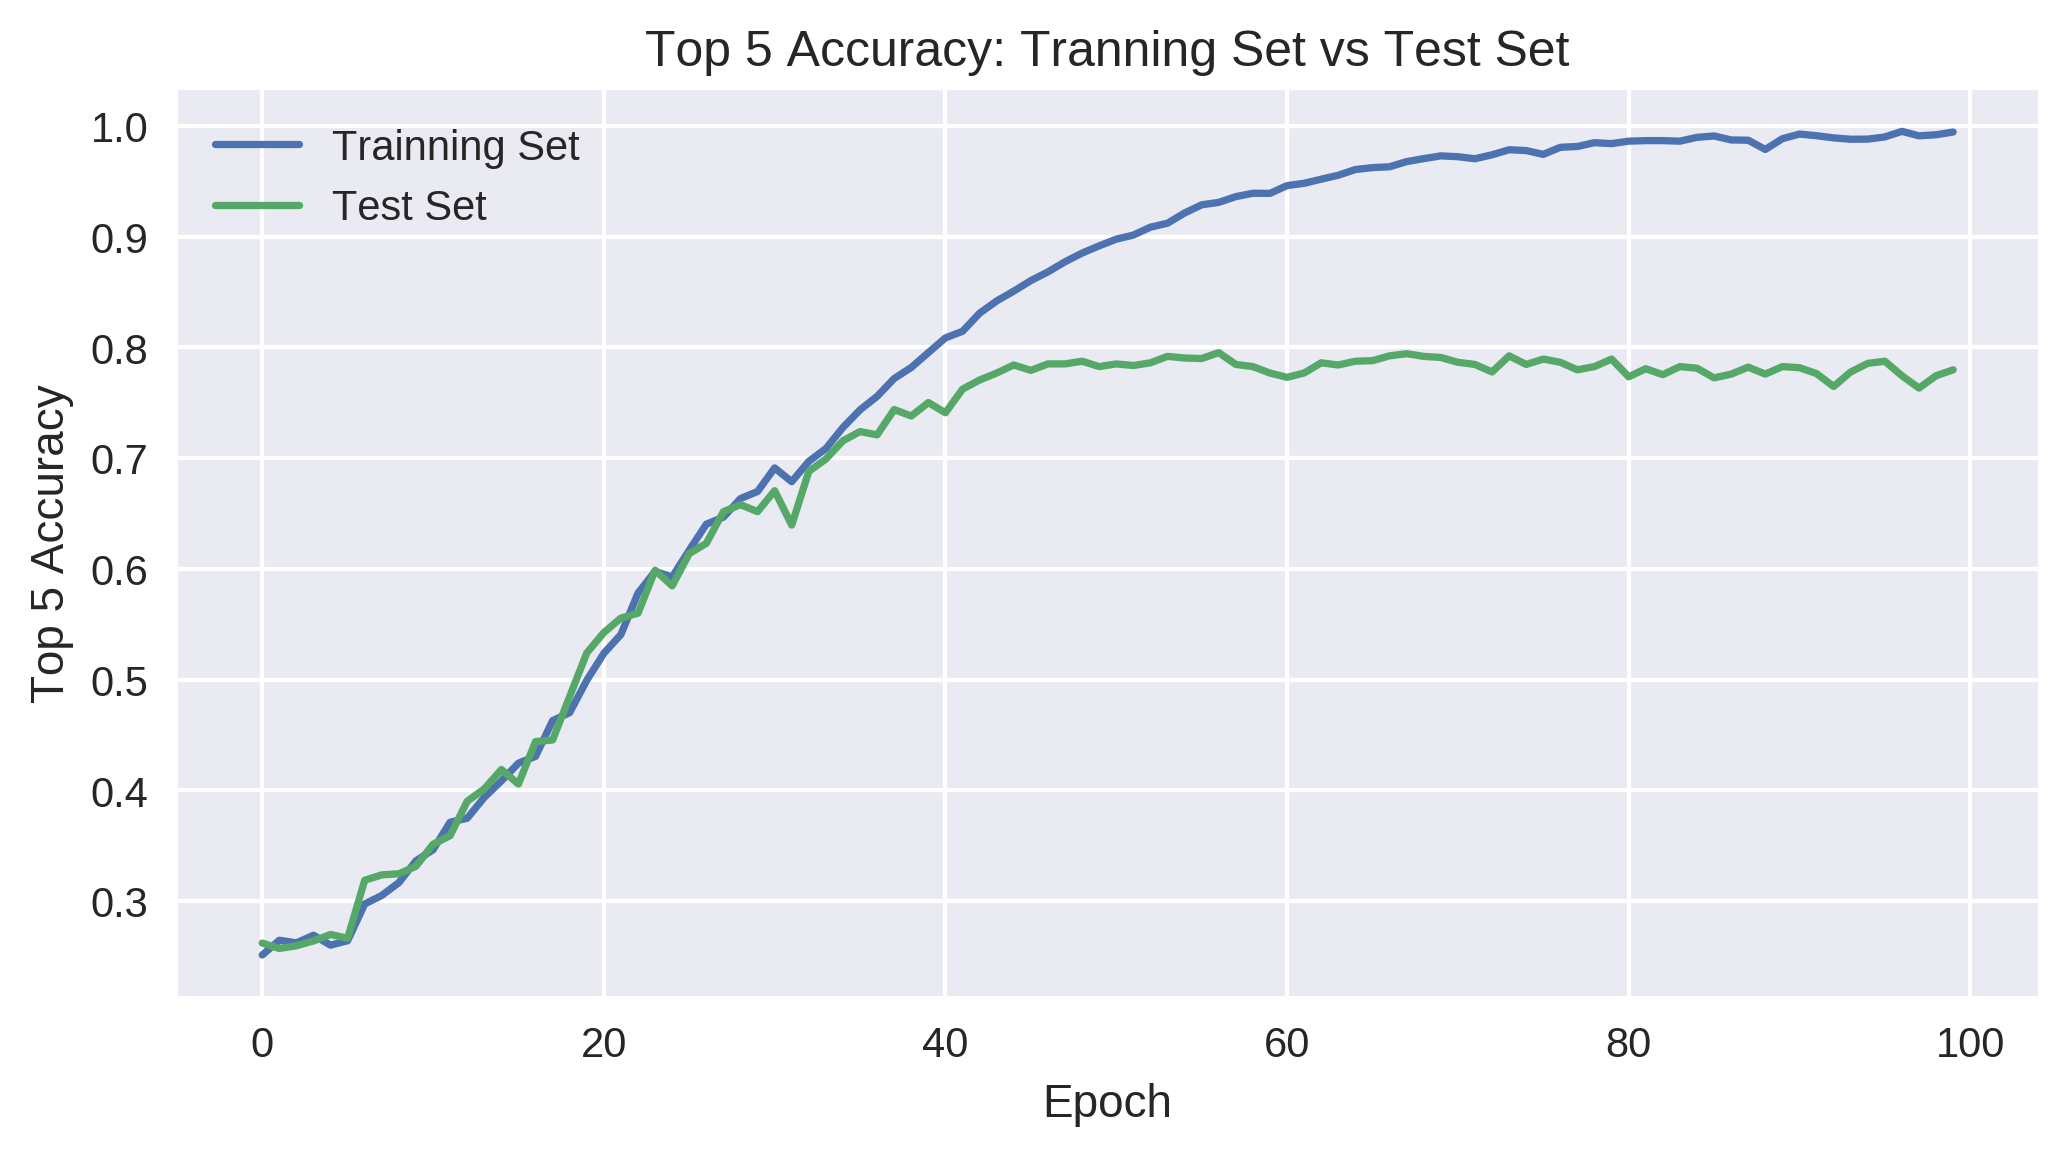

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig('glove50-top5.pdf', format='pdf', dpi=300)

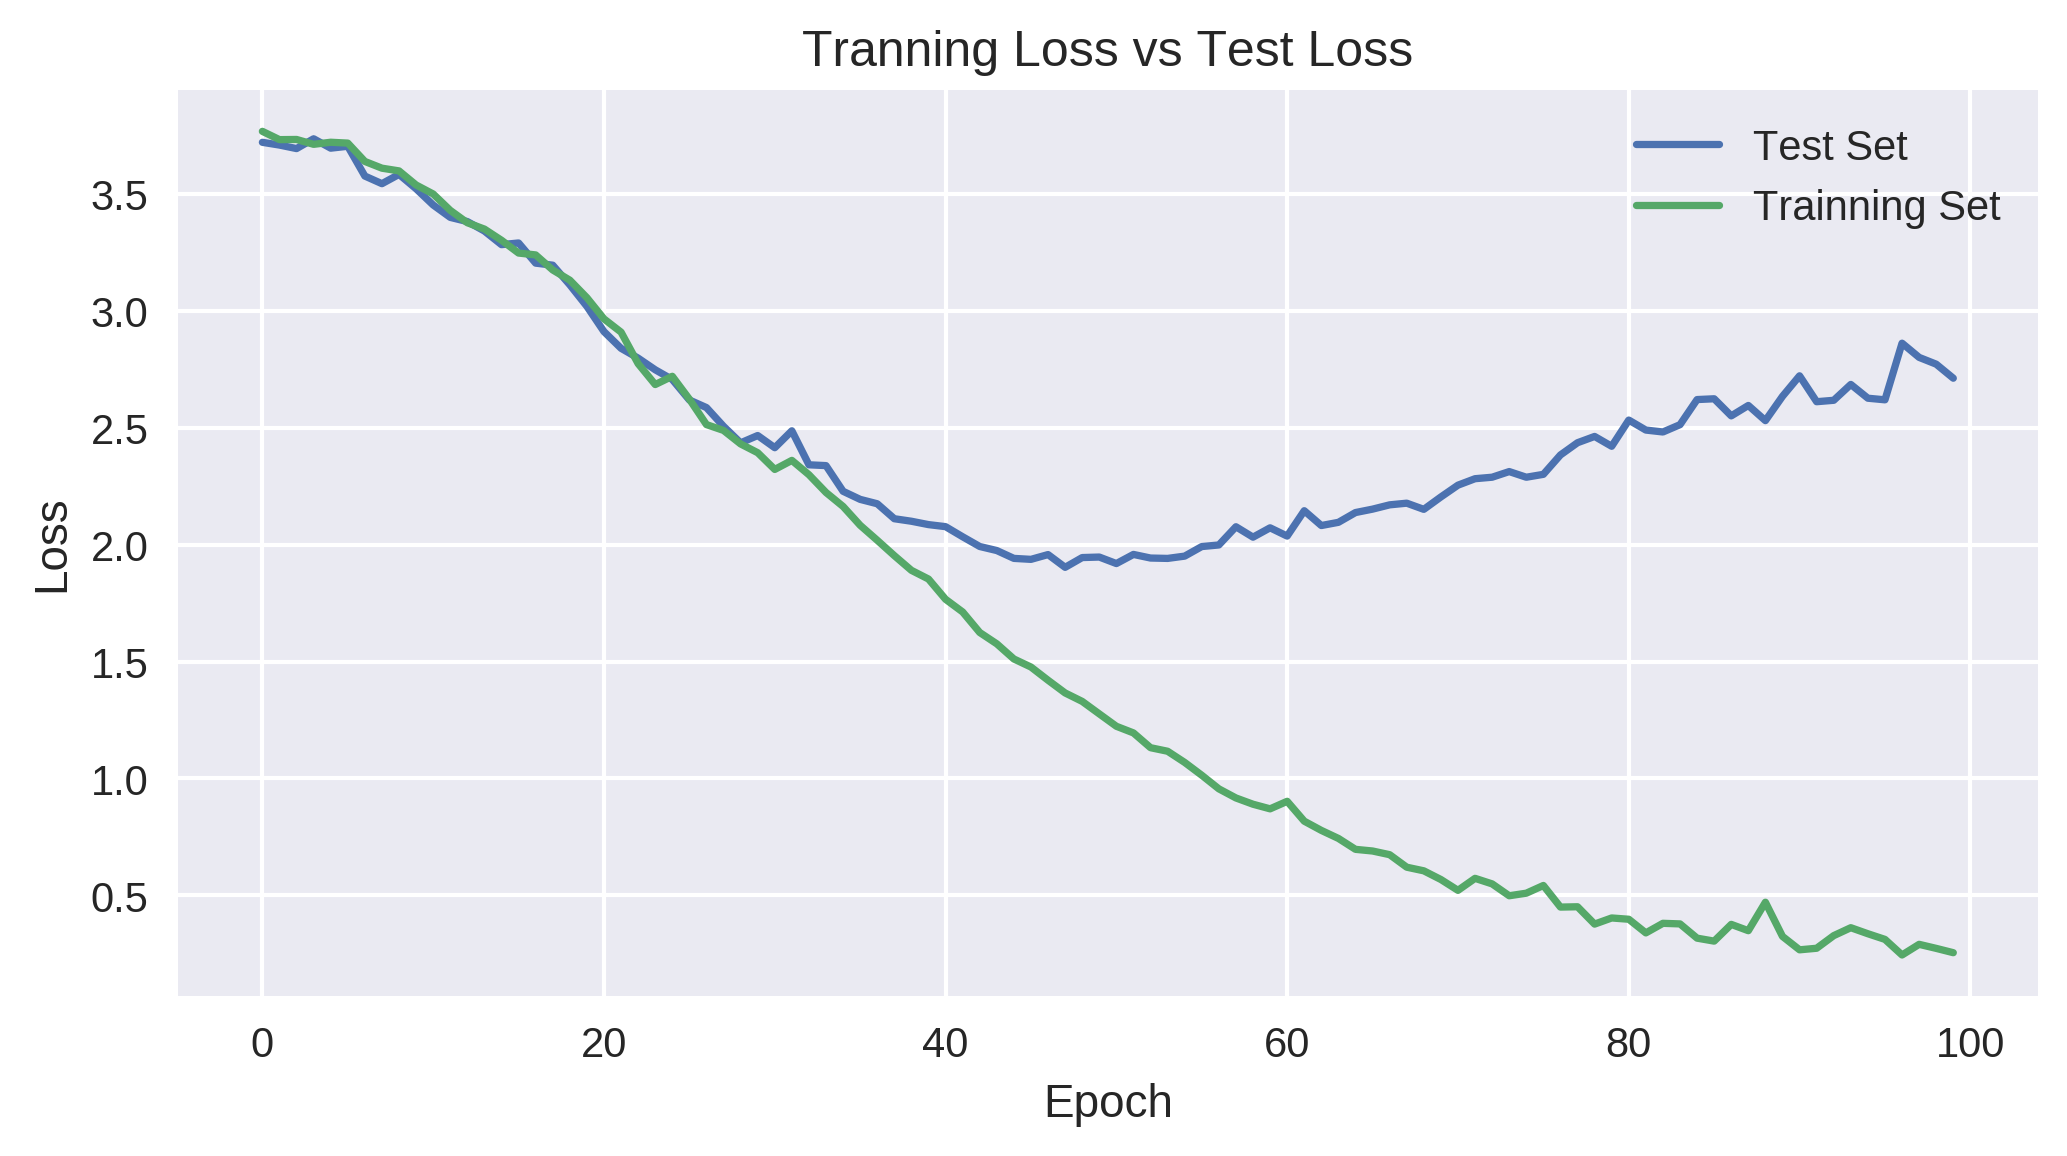

In [0]:
# plot metrics

plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('glove50-loss.pdf', format='pdf', dpi=300)

### Model Save

In [0]:
model.save('Serve_Net_Glove50.h5') 

### Model Load

In [0]:
model = load_model('Serve_Net_Glove50.h5')

In [0]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 33s 4ms/step
Training accuracy =  0.9981533916040871
Test set:
2061/2061 [==============================] - 8s 4ms/step
Training accuracy =  0.7797185833566342


In [0]:
import keras; print(keras.__version__)

2.1.6


In [0]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

NameError: ignored

You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples. 

In [0]:
# This code allows you to see the mislabelled examples
C = 50
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

IndexError: ignored

Now you can try it on your own example. Write your own sentence below. 

In [0]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

Previously, Emojify-V1 model did not correctly label "not feeling happy," but our implementation of Emojiy-V2 got it right. (Keras' outputs are slightly random each time, so you may not have obtained the same result.) The current model still isn't very robust at understanding negation (like "not happy") because the training set is small and so doesn't have a lot of examples of negation. But if the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding such complex sentences. 


In [0]:
import pandas as pd

print(Y_test.shape)
# print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
cross = pd.crosstab(Y_test, pred_test.reshape(len(pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)

f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()

ax.xaxis.set_label_position('top')

# ax.yaxis.set_label_position('right')

ax.set_xticklabels(list(index_to_category.values()), minor=False, rotation=90)
ax.set_yticklabels(list(index_to_category.values()), minor=False, rotation=90)

plt.yticks(rotation=0) 

plt.savefig('heatmap.pdf', format='pdf', dpi=300)

# plot_confusion_matrix(Y_test, pred_test)

(2061, 50)


NameError: ignored